In [1]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
import csv
import json
import array as array
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat

Welcome to JupyROOT 6.18/00


In [2]:
dir_str = '/02_08_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')            

In [4]:
outstr = 'time_v7'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

243.48
13360


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


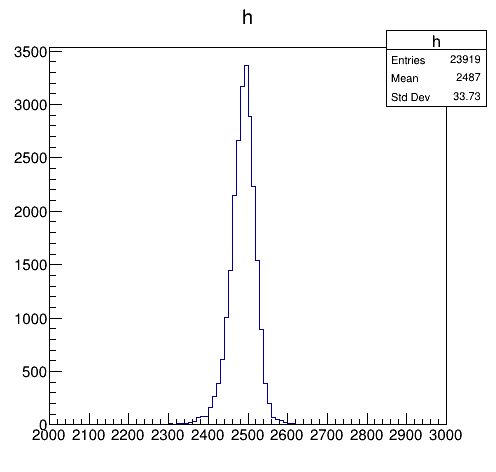

In [28]:
reload(crystMap)

canvas_num=0
c = ROOT.TCanvas("c","c",500,500)
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energy  = str(energies[-1])
print energy
run = dict_C3_energy_scan[energy][0]
tree = ROOT.TChain("h4")
tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
print run
selection = 'fit_ampl[MCP1]>100 && fit_ampl[%s]>1000 && n_tracks==1 && fabs(X-(%.2f))<4 && fabs(Y-(%.2f))<4'%(crystal,dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1])
hist = ROOT.TH1F('h','h',100,2000,3000)
tree.Draw("((fit_time[%s]-fit_time[MCP1]+fit_time[VFE_CLK])-int((fit_time[%s]-fit_time[MCP1]+fit_time[VFE_CLK])/6.238)*6.238)*1000>>h"%(crystal,crystal),selection)
hist.Draw("HIST")
c.Draw()

# Prepare time data for the minimization

In [5]:
import pandas as pd

crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energy  = str(energies[-1])
print energy
run = dict_C3_energy_scan[energy][0]
tree = ROOT.TChain("h4")
tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
selection = 'fit_ampl[MCP1]>100 && fit_ampl[%s]>1000 && n_tracks==1 && fabs(X-(%.2f))<4 && fabs(Y-(%.2f))<4'%(crystal,dict_crystal_centers[crystal][0],dict_crystal_centers[crystal][1])

pos_cut = 4
data = []
for evt in tree:
    if evt.fit_ampl[evt.MCP1]>100 and evt.fit_ampl[evt.MCP2]>1000 and evt.n_tracks==1 and abs(evt.X[0]-dict_crystal_centers[crystal][0])<pos_cut and abs(evt.Y[0]-dict_crystal_centers[crystal][1])<pos_cut : 
        evt_dict = {}
        evt_dict['Energy'] = evt.Energy
        evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]
        evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]
        evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
        evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
        for xstal in ['C3']:
            evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
            evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
            evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
            evt_dict['dt_ecal_mcp1_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
            evt_dict['dt_ecal_mcp2_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
            evt_dict['dt_mcp2_mcp1_'+xstal] = ((evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
        data.append(evt_dict)

df = pd.DataFrame(data)    


243.48


Warning in <TClass::Init>: no dictionary for class PositionMeasurement is available
Warning in <TClass::Init>: no dictionary for class TrackPar is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayer is available
Warning in <TClass::Init>: no dictionary for class Tracking::TelescopeLayout is available
Warning in <TClass::Init>: no dictionary for class CfgManager is available


In [12]:
np.array(list(df['dt_ecal_mcp1_C3']))

array([2511.18978882, 2485.65611267, 2541.64044189, ..., 2478.13439941,
       2489.04252625, 2525.52056885])

In [6]:
gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')


0

In [38]:
from array import array
time_minimizer = ROOT.LLminimizer(array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])), 
                           array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),
                           array('d',list(df['dt_mcp2_mcp1_C3'])),crystal,energy)


TypeError: none of the 3 overloaded methods succeeded. Full details:
  LLminimizer::LLminimizer(vector<double> mcp1_ampl, vector<double> mcp2_ampl, vector<double> dt_ecal_mcp1, vector<double> dt_ecal_mcp2, vector<double> dt_mcp2_mcp1, TString crystal, TString energy) =>
    could not convert argument 1
  LLminimizer::LLminimizer(const LLminimizer&) =>
    takes at most 1 arguments (7 given)
  LLminimizer::LLminimizer(LLminimizer&&) =>
    takes at most 1 arguments (7 given)

In [31]:
#test=array('d',list(df['fit_ampl_MCP1']))


0

In [9]:

from ROOT import std
b = std.vector('double')(10)
time_minimizer = ROOT.LLminimizer(b,b,b,b,b,crystal,energy)

In [10]:
time_minimizer

In [63]:
b = std.vector('double')(10)

In [62]:
v = std.vector(ROOT.Double)()
v += [5,6,7,8]

SystemError: none of the 2 overloaded methods succeeded. Full details:
  void vector<double>::push_back(const double& __x) =>
    problem in C++; program state has been reset
  void vector<double>::push_back(double&& __x) =>
    could not convert argument 1 (this method can not (yet) be called)

IncrementalExecutor::executeFunction: symbol '_ZSt8_DestroyIPddEvT_S1_RSaIT0_E' unresolved while linking symbol '__cf_32'!
You are probably missing the definition of void std::_Destroy<double*, double>(double*, double*, std::allocator<double>&)
Maybe you need to load the corresponding shared library?
Error in <TClingCallFunc::make_wrapper>: Failed to compile
  ==== SOURCE BEGIN ====
#pragma clang diagnostic push
#pragma clang diagnostic ignored "-Wformat-security"
__attribute__((used)) extern "C" void __cf_32(void* obj, int nargs, void** args, void* ret)
{
   ((vector<double>*)obj)->push_back((const double&)*(const double*)args[0]);
   return;
}
#pragma clang diagnostic pop
  ==== SOURCE END ====

 *** Break *** segmentation violation


In [58]:
print b

{ 1.2000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000, 0.0000000 }
